# Loading Dataset

You can download the dataset from {https://challenge.isic-archive.com/data/#2018}.
The data from **Task 3** will be used.


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras
import seaborn as sns
import tensorflow as tf
import os
import numpy as np
from PIL import Image


# Replace these paths with the actual paths to your dataset folders
data_folder = "/content/drive/MyDrive/dl/ISIC2018_Task3_Training_Input"
ground_truth_folder = "/content/drive/MyDrive/dl/ISIC2018_Task3_Training_GroundTruth"

csv_file_path = os.path.join(ground_truth_folder, "ISIC2018_Task3_Training_GroundTruth.csv")
df = pd.read_csv(csv_file_path)

image_data = []
labels = []

for index, row in df.iterrows():
    image_title = row['image']
    label = row.drop('image', axis=0)

    image_path = os.path.join(data_folder, image_title + ".jpg")

    try:
        with Image.open(image_path) as image:
            if image is not None:
                # Resize images
                im = image.resize((120,150), Image.LANCZOS)
                # Append image and label to respective lists
                image_data.append(np.array(im))
                labels.append(label)
            else:
                print(f"Error opening image '{image_path}': NoneType object returned")
    except Exception as e:
        print(f"Error opening image '{image_path}': {e}")

tr_labels = np.array(labels)
image_matrix = np.array([np.array(img) for img in image_data])

np.save("/content/drive/MyDrive/dl/data.npy",image_matrix)
np.save("/content/drive/MyDrive/dl/labels.npy",tr_labels)

# Class mapping
class_mapping = {
    tuple([1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]): "Melanoma",
    tuple([0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]): "Melanocytic nevi",
    tuple([0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]): "Basal cell carcinoma",
    tuple([0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]): "Acaic",
    tuple([0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]): "Benign keratosis-like lesions",
    tuple([0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]): "Dermatofibroma",
    tuple([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]): "Vascular lesions"
}

# Convert float labels to class names
class_labels = [class_mapping[tuple(label)] for label in tr_labels]
np.save("/content/drive/MyDrive/dl/labels_name.npy",class_labels)



In [ ]:
import numpy as np
file_dir = "/content/drive/MyDrive/dl/"
data = np.load(file_dir + "data.npy")
labels = np.load(file_dir + "labels.npy", allow_pickle=True)
class_labels = np.load(file_dir + "labels_name.npy")


## Preprocessing

In [ ]:
from sklearn.model_selection import train_test_split

test_ratio = 0.2
validation_ratio = 0.2

temp_data, test_data, temp_labels, test_labels = train_test_split(data, labels, test_size=test_ratio, random_state=42, stratify=labels)
train_data, validation_data, train_labels, validation_labels = train_test_split(temp_data, temp_labels, test_size=validation_ratio, random_state=42, stratify=temp_labels)

print("Train data shape:", train_data.shape)
print("Validation data shape:", validation_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (6409, 150, 120, 3)
Validation data shape: (1603, 150, 120, 3)
Test data shape: (2003, 150, 120, 3)


In [ ]:
train_data = train_data.astype('float32') / 255.0
validation_data = validation_data.astype('float32') / 255.0
test_data = test_data.astype('float32') / 255.0

train_labels = train_labels.astype('float32')
validation_labels = validation_labels.astype('float32')
test_labels = test_labels.astype('float32')

# Visualizing Sample images

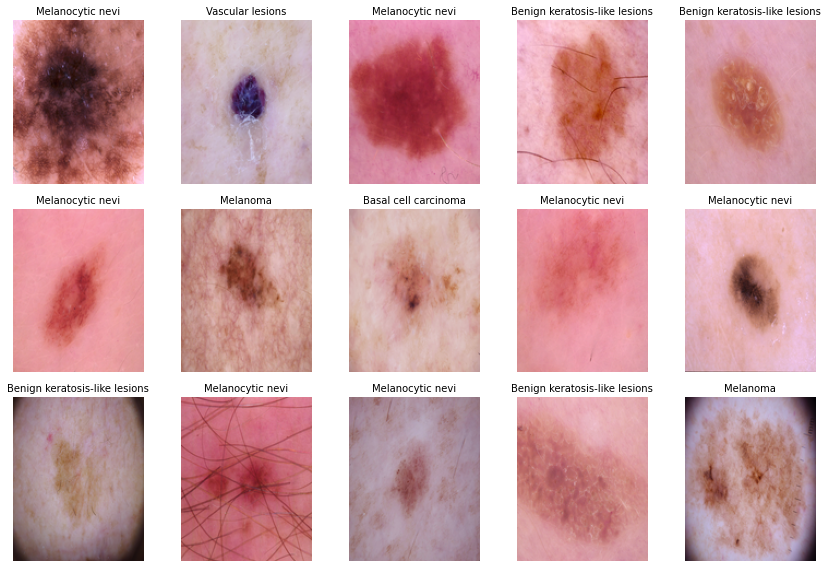

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

random_indices = np.random.choice(len(test_data), size=15, replace=False)

selected_images = test_data[random_indices]
selected_labels = test_labels[random_indices]

plt.figure(figsize=(12, 8))
for i in range(15):
    plt.subplot(3, 5, 1 + i)
    plt.imshow(selected_images[i])
    label_array = selected_labels[i]
    label_text = class_mapping.get(tuple(label_array), "Unknown")
    plt.title(label_text, fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()

# Visualize Class Label Distribution

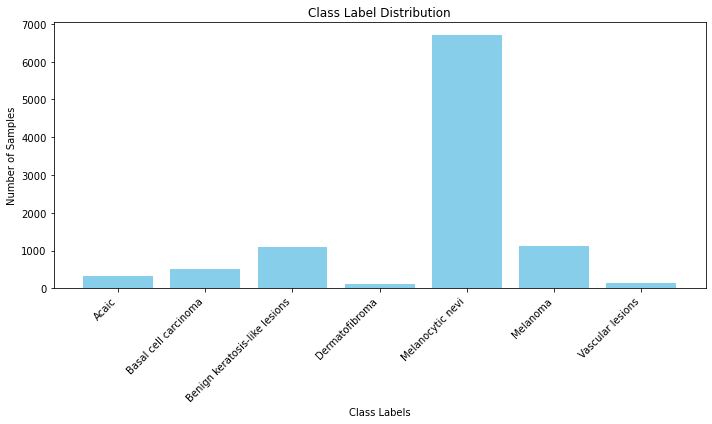

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

unique_classes, class_counts = np.unique(class_labels, return_counts=True)

plt.figure(figsize=(10, 6))
plt.bar(unique_classes, class_counts, color='skyblue')
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')
plt.title('Class Label Distribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Baseline Model

In [ ]:
from tensorflow import keras
from keras import Sequential,layers

baseline_model = Sequential(
    [
        keras.Input(shape = train_data.shape[1:]),
        layers.Conv2D(64, (3,3), activation = "relu", padding = "same"),
        layers.Conv2D(32, (3,3), activation = "relu", padding = "same"),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation = "relu", padding = "same"),
        layers.Conv2D(32, (3,3), activation = "relu", padding = "same"),
        layers.MaxPooling2D((2,2))
    ]
)
# Add a Flatten layer to the model
baseline_model.add(layers.Flatten())
# Add 2 Dense layers with 32 units and relu activation
baseline_model.add(layers.Dense(32, activation="relu"))
baseline_model.add(layers.Dense(32, activation="relu"))
# Add the last Dense layer.
baseline_model.add(layers.Dense(7, activation = "softmax"))

baseline_model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 150, 120, 64)      1792      
                                                                 
 conv2d_17 (Conv2D)          (None, 150, 120, 32)      18464     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 75, 60, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 75, 60, 64)        18496     
                                                                 
 conv2d_19 (Conv2D)          (None, 75, 60, 32)        18464     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 37, 30, 32)        0         
 g2D)                                                 

In [ ]:

baseline_model.compile(optimizer="Adam", loss = "categorical_crossentropy",metrics = ["accuracy"])

history=baseline_model.fit(train_data, train_labels, batch_size = 32, epochs = 10, validation_data=(validation_data, validation_labels))
test_loss, test_acc = baseline_model.evaluate(test_data, test_labels)



Epoch 1/10
201/201 [==============================] - 12s 51ms/step - loss: 1.0332 - accuracy: 0.6669 - val_loss: 0.9511 - val_accuracy: 0.6719
Epoch 2/10
201/201 [==============================] - 9s 43ms/step - loss: 0.9350 - accuracy: 0.6764 - val_loss: 0.8869 - val_accuracy: 0.6725
Epoch 3/10
201/201 [==============================] - 9s 43ms/step - loss: 0.8837 - accuracy: 0.6862 - val_loss: 0.9126 - val_accuracy: 0.6856
Epoch 4/10
201/201 [==============================] - 9s 42ms/step - loss: 0.8452 - accuracy: 0.6940 - val_loss: 0.8393 - val_accuracy: 0.6806
Epoch 5/10
201/201 [==============================] - 8s 42ms/step - loss: 0.8115 - accuracy: 0.7062 - val_loss: 0.9667 - val_accuracy: 0.6868
Epoch 6/10
201/201 [==============================] - 8s 41ms/step - loss: 0.7894 - accuracy: 0.7168 - val_loss: 0.7881 - val_accuracy: 0.7093
Epoch 7/10
201/201 [==============================] - 8s 42ms/step - loss: 0.7338 - accuracy: 0.7330 - val_loss: 0.8178 - val_accuracy: 0.712

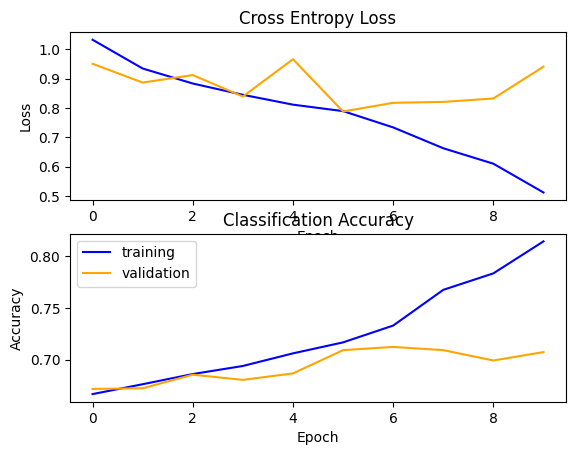

In [ ]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['training', 'validation'])
    plt.show()

summarize_diagnostics(history)

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp

validation_predictions = baseline_model.predict(validation_data)
test_predictions = baseline_model.predict(test_data)


fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(7):
    y_true = validation_labels[:, i]

    y_score = validation_predictions[:, i]

    fpr[i], tpr[i], _ = roc_curve(y_true, y_score)

    roc_auc[i] = auc(fpr[i], tpr[i])


63/63 [==============================] - 1s 10ms/step


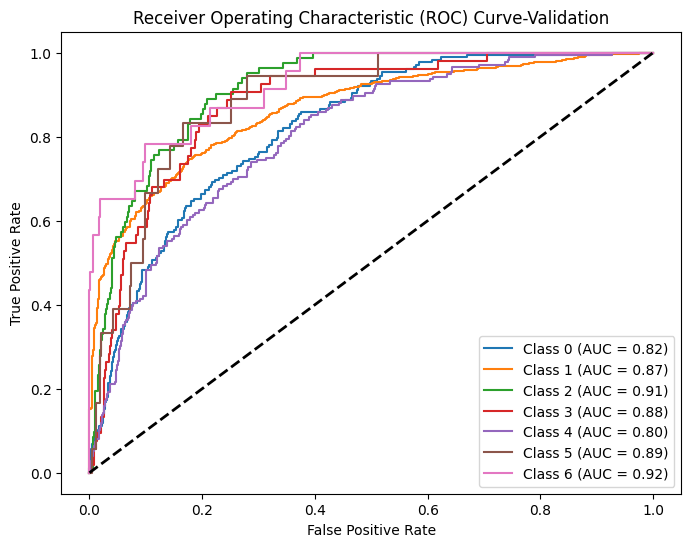

In [ ]:

plt.figure(figsize=(8, 6))
for i in range(7):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve-Validation')
plt.legend(loc='lower right')
plt.show()

In [ ]:

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(7):
    y_true = test_labels[:, i]

    y_score = test_predictions[:, i]

    fpr[i], tpr[i], _ = roc_curve(y_true, y_score)

    roc_auc[i] = auc(fpr[i], tpr[i])

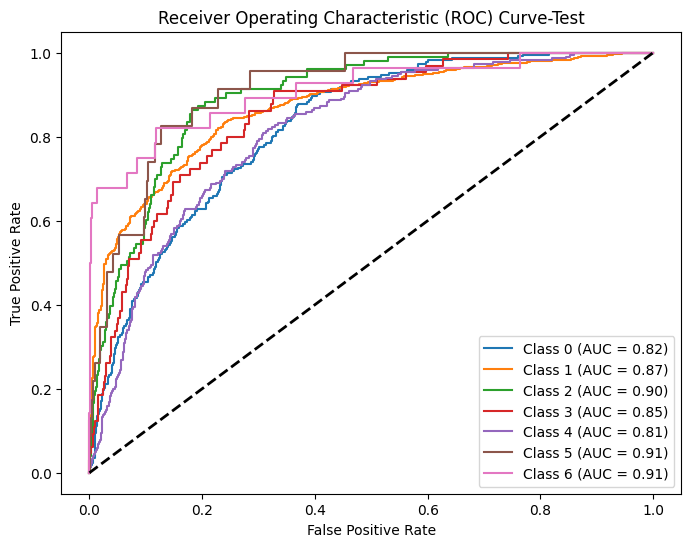

In [ ]:

plt.figure(figsize=(8, 6))
for i in range(7):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve-Test')
plt.legend(loc='lower right')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix_val = confusion_matrix(validation_labels.argmax(axis=1), validation_predictions.argmax(axis=1))

confusion_matrix_test = confusion_matrix(test_labels.argmax(axis=1), test_predictions.argmax(axis=1))

print("Confusion Matrix for Validation Set:")
print(confusion_matrix_val)

print("\nConfusion Matrix for Test Set:")
print(confusion_matrix_test)

Confusion Matrix for Validation Set:
[[ 53 100   2   2  21   0   0]
 [ 39 966  17   8  42   1   0]
 [  1  27  33   4  16   1   0]
 [  8  11  14   4  14   2   0]
 [ 20  71  13   5  67   0   0]
 [  1   4   6   2   5   0   0]
 [  0   4   3   0   4   1  11]]

Confusion Matrix for Test Set:
[[  70  110    6    6   31    0    0]
 [  59 1201   18    2   58    1    2]
 [   5   31   37    6   22    0    2]
 [  12   17   15    6   15    0    0]
 [  25   95   11    3   86    0    0]
 [   0    6    8    2    6    1    0]
 [   2    6    4    1    0    1   14]]


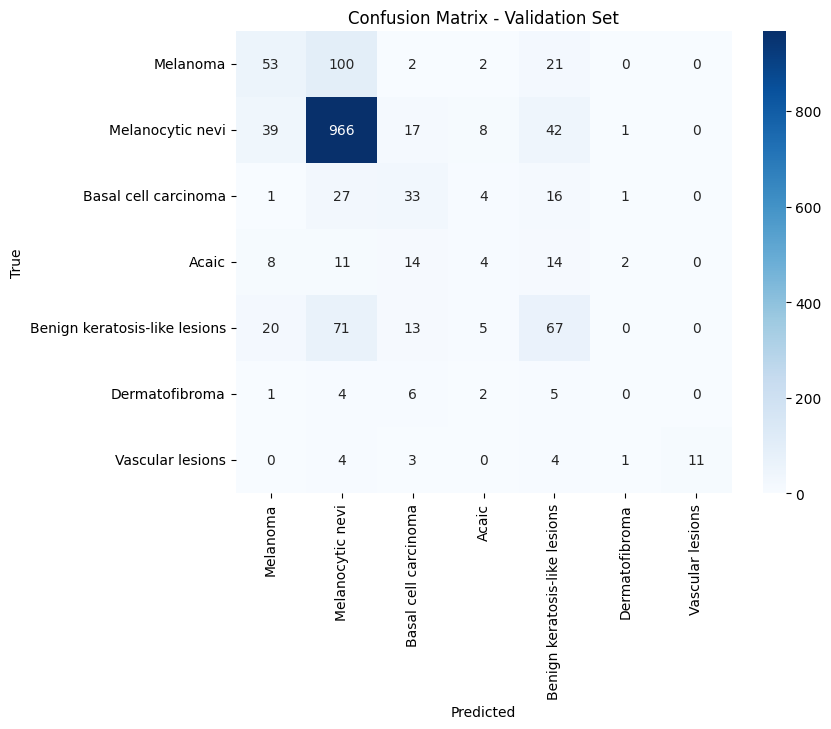

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

class_labels = ["Melanoma", "Melanocytic nevi", "Basal cell carcinoma", "Acaic", "Benign keratosis-like lesions", "Dermatofibroma", "Vascular lesions"]

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_val, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Validation Set')
plt.show()


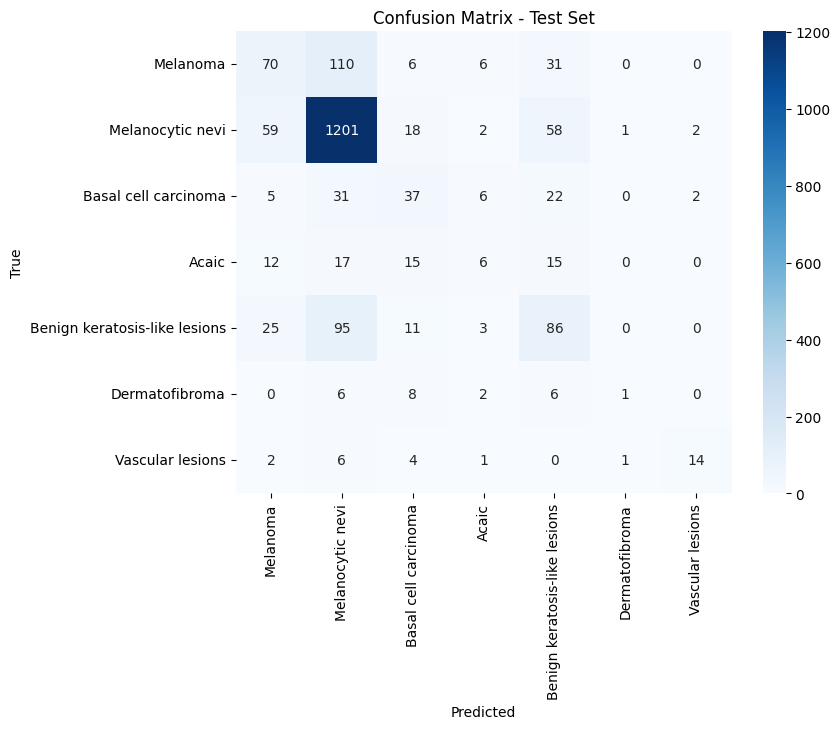

In [ ]:
class_labels = ["Melanoma", "Melanocytic nevi", "Basal cell carcinoma", "Acaic", "Benign keratosis-like lesions", "Dermatofibroma", "Vascular lesions"]

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test Set')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy_val = accuracy_score(validation_labels.argmax(axis=1), validation_predictions.argmax(axis=1))
accuracy_test = accuracy_score(test_labels.argmax(axis=1), test_predictions.argmax(axis=1))

precision_val = precision_score(validation_labels.argmax(axis=1), validation_predictions.argmax(axis=1), average='macro')
recall_val = recall_score(validation_labels.argmax(axis=1), validation_predictions.argmax(axis=1), average='macro')
f1_score_val = f1_score(validation_labels.argmax(axis=1), validation_predictions.argmax(axis=1), average='macro')

print("Validation Set Metrics:")
print(f"Accuracy: {accuracy_val:.4f}")
print(f"Precision: {precision_val:.4f}")
print(f"Recall: {recall_val:.4f}")
print(f"F1 Score: {f1_score_val:.4f}")

precision_test = precision_score(test_labels.argmax(axis=1), test_predictions.argmax(axis=1), average='macro')
recall_test = recall_score(test_labels.argmax(axis=1), test_predictions.argmax(axis=1), average='macro')
f1_score_test = f1_score(test_labels.argmax(axis=1), test_predictions.argmax(axis=1), average='macro')

print("Test Set Metrics:")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"Precision: {precision_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"F1 Score: {f1_score_test:.4f}")

Validation Set Metrics:
Accuracy: 0.7074
Precision: 0.4546
Recall: 0.3621
F1 Score: 0.3909
Validation Set Metrics:
Accuracy: 0.7064
Precision: 0.4763
Recall: 0.3708
F1 Score: 0.3980


## Enhanced Model

In [ ]:
from tensorflow import keras
from keras import Sequential,layers
from tensorflow.keras import regularizers

regularizer=regularizers.l2(0.0005)
dropout_rate=0.2
enhanced_model = Sequential(
    [
        keras.Input(shape = train_data.shape[1:]),
        layers.Conv2D(64, (3,3), activation = "relu", padding = "same"),
        layers.Conv2D(64, (3,3), activation = "relu", padding = "same"),
        layers.Conv2D(32, (3,3), activation = "relu", padding = "same"),
        layers.Conv2D(32, (3,3), activation = "relu", padding = "same"),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation = "relu", padding = "same"),
        layers.Conv2D(64, (3,3), activation = "relu", padding = "same"),
        layers.Conv2D(32, (3,3), activation = "relu", padding = "same"),
        layers.Conv2D(32, (3,3), activation = "relu", padding = "same"),
        layers.MaxPooling2D((2,2))
    ]
)
enhanced_model.add(layers.Flatten())

enhanced_model.add(layers.Dense(32, activation="relu", kernel_regularizer=regularizer))
enhanced_model.add(layers.Dropout(dropout_rate))
enhanced_model.add(layers.Dense(32, activation="relu", kernel_regularizer=regularizer))
enhanced_model.add(layers.Dropout(dropout_rate))

enhanced_model.add(layers.Dense(7, activation = "softmax"))

enhanced_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 150, 120, 64)      1792      
                                                                 
 conv2d_21 (Conv2D)          (None, 150, 120, 32)      18464     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 75, 60, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 75, 60, 64)        18496     
                                                                 
 conv2d_23 (Conv2D)          (None, 75, 60, 32)        18464     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 37, 30, 32)        0         
 ng2D)                                                

In [ ]:
#use SMOTE to balance the data
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='auto')
train_data_smote, train_labels_smote = smote.fit_resample(train_data.reshape(-1, 120*150*3), train_labels)
train_data_smote = train_data_smote.reshape(-1, 120, 150, 3)

# visualize the class distribution after SMOTE
unique_classes, class_counts = np.unique(train_labels_smote, return_counts=True)

plt.figure(figsize=(10, 6))
plt.bar(unique_classes, class_counts, color='skyblue')
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')
plt.title('Class Label Distribution After SMOTE')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
from keras.callbacks import EarlyStopping

optimizer="Adam"
batch_size = 32
epochs = 100

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)
enhanced_model.compile(optimizer=optimizer, loss = "categorical_crossentropy",metrics = ["accuracy"])

history=enhanced_model.fit(train_data_smote, train_labels_smote, batch_size = batch_size, epochs = epochs, validation_data=(validation_data, validation_labels),callbacks=[early_stopping])

Epoch 1/100
601/601 [==============================] - 28s 43ms/step - loss: 1.0750 - accuracy: 0.6675 - val_loss: 0.9502 - val_accuracy: 0.6694
Epoch 2/100
601/601 [==============================] - 24s 41ms/step - loss: 1.0011 - accuracy: 0.6699 - val_loss: 0.9537 - val_accuracy: 0.6694
Epoch 3/100
601/601 [==============================] - 24s 40ms/step - loss: 0.9525 - accuracy: 0.6697 - val_loss: 0.8998 - val_accuracy: 0.6675
Epoch 4/100
601/601 [==============================] - 24s 40ms/step - loss: 0.9278 - accuracy: 0.6733 - val_loss: 0.9124 - val_accuracy: 0.6681
Epoch 5/100
601/601 [==============================] - 24s 40ms/step - loss: 0.8972 - accuracy: 0.6761 - val_loss: 0.8776 - val_accuracy: 0.6781
Epoch 6/100
601/601 [==============================] - 24s 40ms/step - loss: 0.8830 - accuracy: 0.6838 - val_loss: 0.8395 - val_accuracy: 0.6918
Epoch 7/100
601/601 [==============================] - 24s 40ms/step - loss: 0.8725 - accuracy: 0.6898 - val_loss: 0.8193 - val_ac

In [ ]:
test_loss, test_acc = enhanced_model.evaluate(test_data, test_labels)

63/63 [==============================] - 1s 12ms/step - loss: 0.7668 - accuracy: 0.7369


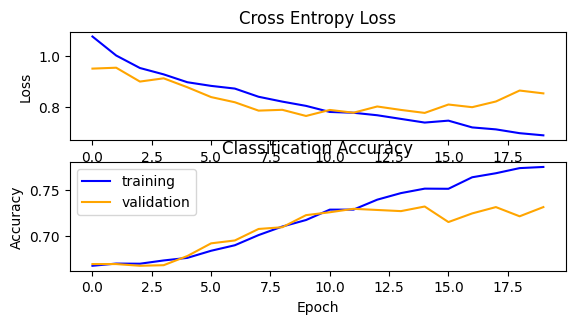

In [ ]:

def summarize_diagnostics(history):
    plt.subplot(311)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(312)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['training', 'validation'])
    plt.show()

summarize_diagnostics(history)

63/63 [==============================] - 1s 10ms/step


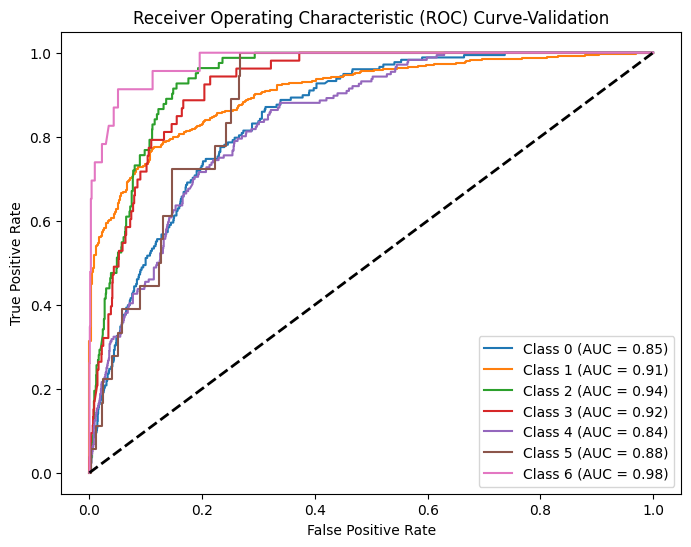

In [ ]:
validation_predictions = enhanced_model.predict(validation_data)
test_predictions = enhanced_model.predict(test_data)


fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(7):
    y_true = validation_labels[:, i]

    y_score = validation_predictions[:, i]

    fpr[i], tpr[i], _ = roc_curve(y_true, y_score)

    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(7):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve-Validation')
plt.legend(loc='lower right')
plt.show()

In [ ]:

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(7):
    y_true = test_labels[:, i]

    y_score = test_predictions[:, i]

    fpr[i], tpr[i], _ = roc_curve(y_true, y_score)

    roc_auc[i] = auc(fpr[i], tpr[i])


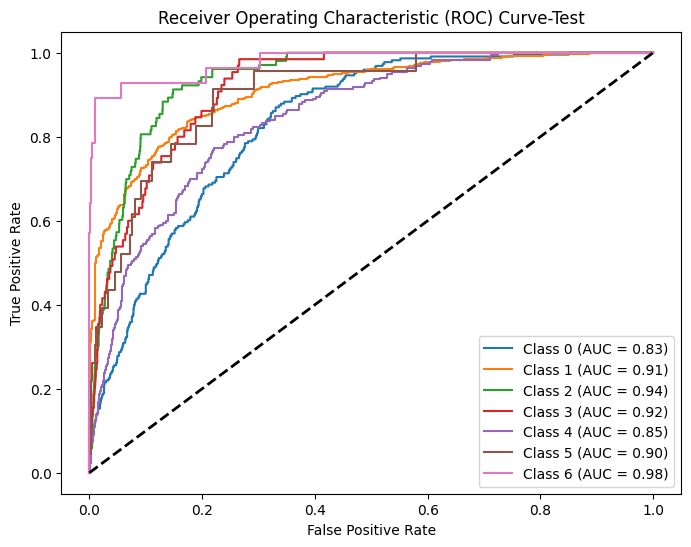

In [ ]:

plt.figure(figsize=(8, 6))
for i in range(7):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve-Test')
plt.legend(loc='lower right')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix for validation set
confusion_matrix_val = confusion_matrix(validation_labels.argmax(axis=1), validation_predictions.argmax(axis=1))

# Calculate confusion matrix for test set
confusion_matrix_test = confusion_matrix(test_labels.argmax(axis=1), test_predictions.argmax(axis=1))

print("Confusion Matrix for Validation Set:")
print(confusion_matrix_val)

print("\nConfusion Matrix for Test Set:")
print(confusion_matrix_test)

Confusion Matrix for Validation Set:
[[  32  107    4    0   33    0    2]
 [  20 1003   15    0   34    0    1]
 [   0   25   42    0   14    0    1]
 [   0   11   18    0   24    0    0]
 [   9   77   21    0   69    0    0]
 [   0    7    7    0    4    0    0]
 [   0    3    8    0    0    0   12]]

Confusion Matrix for Test Set:
[[  40  128    9    0   46    0    0]
 [   9 1269   13    0   49    0    1]
 [   0   27   44    0   31    0    1]
 [   1   19   23    0   22    0    0]
 [  10   96   10    0  103    0    1]
 [   0   13    8    0    1    0    1]
 [   0    4    2    0    2    0   20]]


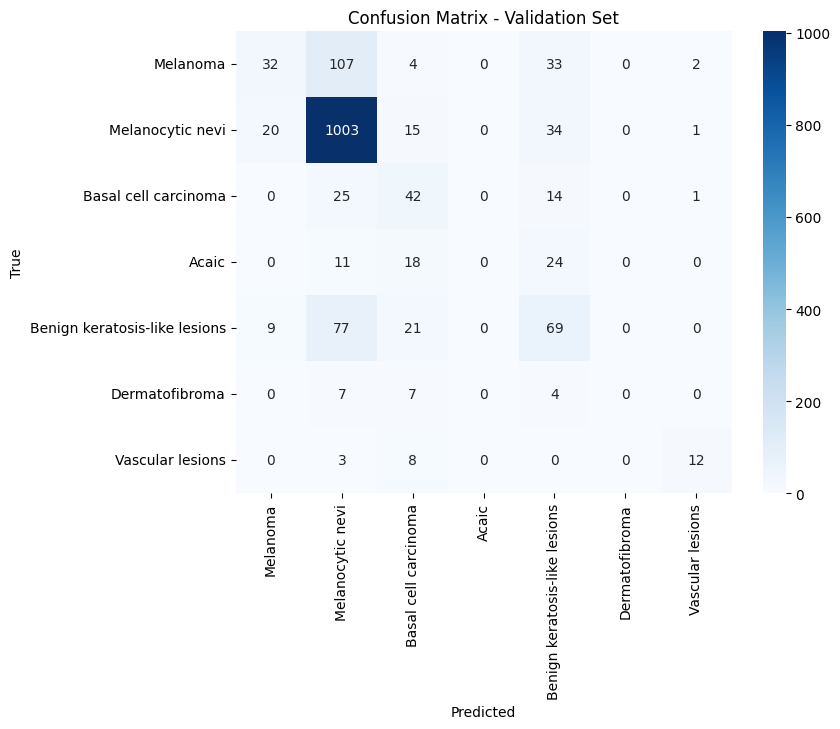

In [ ]:

class_labels = ["Melanoma", "Melanocytic nevi", "Basal cell carcinoma", "Acaic", "Benign keratosis-like lesions", "Dermatofibroma", "Vascular lesions"]

# Create a heatmap with labels
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_val, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Validation Set')
plt.show()

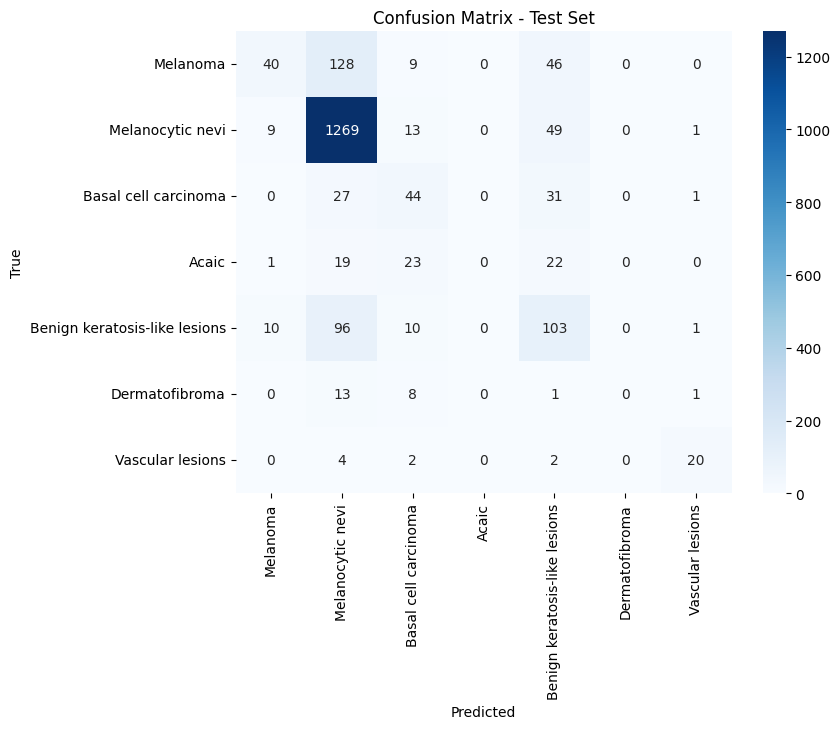

In [ ]:
# test
class_labels = ["Melanoma", "Melanocytic nevi", "Basal cell carcinoma", "Acaic", "Benign keratosis-like lesions", "Dermatofibroma", "Vascular lesions"]

# Create a heatmap with labels
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test Set')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy_val = accuracy_score(validation_labels.argmax(axis=1), validation_predictions.argmax(axis=1))
accuracy_test = accuracy_score(test_labels.argmax(axis=1), test_predictions.argmax(axis=1))

# Calculate precision, recall, and F1-score
precision_val = precision_score(validation_labels.argmax(axis=1), validation_predictions.argmax(axis=1), average='macro')
recall_val = recall_score(validation_labels.argmax(axis=1), validation_predictions.argmax(axis=1), average='macro')
f1_score_val = f1_score(validation_labels.argmax(axis=1), validation_predictions.argmax(axis=1), average='macro')

print("Validation Set Metrics:")
print(f"Accuracy: {accuracy_val:.4f}")
print(f"Precision: {precision_val:.4f}")
print(f"Recall: {recall_val:.4f}")
print(f"F1 Score: {f1_score_val:.4f}")

# test set
precision_test = precision_score(test_labels.argmax(axis=1), test_predictions.argmax(axis=1), average='macro')
recall_test = recall_score(test_labels.argmax(axis=1), test_predictions.argmax(axis=1), average='macro')
f1_score_test = f1_score(test_labels.argmax(axis=1), test_predictions.argmax(axis=1), average='macro')

print("Test Set Metrics:")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"Precision: {precision_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"F1 Score: {f1_score_test:.4f}")

Validation Set Metrics:
Accuracy: 0.7224
Precision: 0.4058
Recall: 0.3629
F1 Score: 0.3670
Validation Set Metrics:
Accuracy: 0.7369
Precision: 0.4464
Recall: 0.3908
F1 Score: 0.3968


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Transfer Learning Model

In [ ]:
# transfer learning
from tensorflow import keras
from keras import Sequential,layers

from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input

vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(120, 150, 3))

for layer in vgg_model.layers:
    layer.trainable = False

transfer_model = Sequential()
transfer_model.add(vgg_model)
transfer_model.add(layers.Flatten())
transfer_model.add(layers.Dense(128, activation='relu'))
transfer_model.add(layers.Dense(7, activation='softmax'))

transfer_model.summary()

In [ ]:
#train the model
optimizer="Adam"
batch_size = 32
epochs = 100

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)
transfer_model.compile(optimizer=optimizer, loss = "categorical_crossentropy",metrics = ["accuracy"])

history=transfer_model.fit(train_data, train_labels, batch_size = batch_size, epochs = epochs, validation_data=(validation_data, validation_labels),callbacks=[early_stopping])

test_loss, test_acc = transfer_model.evaluate(test_data, test_labels)

summarize_diagnostics(history)

validation_predictions = transfer_model.predict(validation_data)
test_predictions = transfer_model.predict(test_data)



In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(7):
    y_true = validation_labels[:, i]

    y_score = validation_predictions[:, i]

    fpr[i], tpr[i], _ = roc_curve(y_true, y_score)

    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(7):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve-Validation')
plt.legend(loc='lower right')
plt.show()
